In [1]:
# Load datasets from saved pickle files
import pandas as pd
import os

import os, json, pickle, random, time

import xgboost as xgb
import numpy as np
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    precision_recall_curve, auc,
    accuracy_score
)

from sklearn.utils import compute_sample_weight



In [6]:
import os
import pickle
import random
import time
import json

import numpy as np
import xgboost as xgb

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    accuracy_score, f1_score
)
from sklearn.model_selection  import StratifiedKFold
from sklearn.utils            import compute_sample_weight

# ————————————————————————————————————————————————
def load_history(path):
    if os.path.exists(path):
        return pickle.load(open(path, 'rb'))
    return {
        'tried_params': {},
        'best': {
            'params':     None,
            'f1_val':     0.0,
            'acc_test':   0.0,
            'model_path': None
        }
    }

def save_history(history, path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
    pickle.dump(history, open(path, 'wb'))

def sample_params(space):
    return {
        'n_estimators':      random.randint(*space['n_estimators']),
        'learning_rate':     random.uniform(*space['learning_rate']),
        'max_depth':         random.randint(*space['max_depth']),
        'subsample':         random.uniform(*space['subsample']),
        'colsample_bytree':  random.uniform(*space['colsample_bytree']),
        'objective':         'binary:logistic',
        'eval_metric':       'aucpr',             # still OK for early stopping
        'random_state':      42,
        'early_stopping_rounds': 50
    }

def cv_weighted_f1(params, X, y, sw, n_splits=5):
    """
    Returns the mean weighted-F1 over n_splits stratified folds,
    using sample_weight `sw`.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for tr_idx, val_idx in skf.split(X, y):
        model = xgb.XGBClassifier(**params)
        model.fit(
            X[tr_idx], y[tr_idx],
            sample_weight=sw[tr_idx],
            eval_set=[(X[val_idx], y[val_idx])],
            sample_weight_eval_set=[sw[val_idx]],
            verbose=False
        )
        preds = model.predict(X[val_idx])
        scores.append(f1_score(y[val_idx], preds, average='weighted'))
    return np.mean(scores)

def test_acc(model, X_te, y_te):
    preds = (model.predict_proba(X_te)[:,1] >= 0.5).astype(int)
    return accuracy_score(y_te, preds)

def random_search_xgb_f1(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    param_space,
    results_path,
    best_model_bin
):
    history = load_history(results_path)

    # 1) encode labels once
    le    = LabelEncoder().fit(y_train)
    y_tr  = le.transform(y_train)
    y_vale= le.transform(y_val)
    y_te  = le.transform(y_test)

    # 2) build pool + weights
    X_pool = np.vstack([X_train, X_val])
    y_pool = np.concatenate([y_tr, y_vale])
    sw_pool= compute_sample_weight('balanced', y_pool)

    # also weights for train/val splits for final fit
    sw_tr  = compute_sample_weight('balanced', y_tr)
    sw_val = compute_sample_weight('balanced', y_vale)

    iteration = 0
    try:
        while True:
            iteration += 1
            params = sample_params(param_space)
            key    = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # A) CV weighted-F1 on the pool
            f1_val = cv_weighted_f1(params, X_pool, y_pool, sw_pool, n_splits=5)

            # B) train final model on TRAIN only, early-stop on VAL
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train, y_tr,
                sample_weight=sw_tr,
                eval_set=[(X_val, y_vale)],
                sample_weight_eval_set=[sw_val],
                verbose=False
            )

            # C) test accuracy
            acc_te = test_acc(model, X_test, y_te)

            # record
            history['tried_params'][key] = {
                'f1_val': f1_val,
                'acc_te': acc_te,
                'time':   time.time()
            }

            # D) update best on F1↑ and acc ≥ (or tiebreak)
            best = history['best']
            better_f1      = f1_val > best['f1_val']
            tie_f1         = f1_val == best['f1_val']
            better_acc     = acc_te > best['acc_test']
            not_worse_acc  = acc_te >= best['acc_test']
            if (better_f1 and not_worse_acc) or (tie_f1 and better_acc):
                history['best'] = {
                    'params':     params,
                    'f1_val':     f1_val,
                    'acc_test':   acc_te,
                    'model_path': best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)
                print(f"[Iter {iteration}] 🎉 New best f1_val={f1_val:.4f}, acc_test={acc_te:.4f}")
                print("            params =", params)

            save_history(history, results_path)

    except KeyboardInterrupt:
        save_history(history, results_path)
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   f1_val   = {b['f1_val']:.4f}")
        print(f"   acc_test = {b['acc_test']:.4f}")
        print(f"   params   = {b['params']}")
        print(f"   model    = {b['model_path']}")

# ————————————————————————————————————————————————
# USAGE

PARAM_SPACE = {
    'n_estimators':     (20, 200),
    'learning_rate':    (0.01, 0.3),
    'max_depth':        (2, 30),
    'subsample':        (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

# Call:
# random_search_xgb_f1(
#     X_train_B, y_train_B,
#     X_val_B,   y_val_B,
#     X_test_B,  y_test_B,
#     PARAM_SPACE,
#     'outputs/xgb_f1_search_B.pkl',
#     'outputs/xgb_f1_best_model_B.bin'
# )

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.calibration      import CalibratedClassifierCV

def evaluate_with_auto_threshold(
    model,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    calibrate: bool = True,
    calibrator_method: str = 'sigmoid'
):
    """
    1) Fit LabelEncoder on y_train.
    2) (Optional) Calibrate model on (X_val, y_val).
    3) Find threshold on val that maximizes F1.
    4) Print metrics & classification reports for Val & Test.
    5) Then show all plots (ROC, PR, Confusion Matrices, Importances).
    """
    # --- Encode labels ---
    le = LabelEncoder().fit(y_train)
    y_val_enc, y_test_enc = le.transform(y_val), le.transform(y_test)

    # --- Calibrate if requested ---
    if calibrate:
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val, y_val_enc)
        proba_val  = calibrator.predict_proba(X_val)[:,1]
        proba_test = calibrator.predict_proba(X_test)[:,1]
    else:
        proba_val  = model.predict_proba(X_val)[:,1]
        proba_test = model.predict_proba(X_test)[:,1]

    # --- Find best threshold on validation by F1 ---
    thresholds = np.linspace(0, 1, 101)
    f1_scores  = [f1_score(y_val_enc, (proba_val >= t).astype(int)) for t in thresholds]
    best_idx   = np.argmax(f1_scores)
    best_thr   = thresholds[best_idx]
    print(f"→ Selected threshold = {best_thr:.2f} (F1 on val = {f1_scores[best_idx]:.4f})\n")

    # --- Function to compute & print metrics & report ---
    def print_metrics(y_true_enc, proba, split_name):
        y_pred = (proba >= best_thr).astype(int)
        acc    = accuracy_score(y_true_enc, y_pred)
        prec   = precision_score(y_true_enc, y_pred)
        rec    = recall_score(y_true_enc, y_pred)
        f1     = f1_score(y_true_enc, y_pred)
        rocauc = roc_auc_score(y_true_enc, proba)
        pr_auc = auc(*precision_recall_curve(y_true_enc, proba)[1::-1])

        print(f"{split_name} results @ t={best_thr:.2f}")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  F1-Score : {f1:.4f}")
        print(f"  ROC AUC  : {rocauc:.4f}")
        print(f"  PR AUC   : {pr_auc:.4f}\n")
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names=le.classes_
        ))
        print("-" * 50 + "\n")

    # --- Print Val and Test metrics & reports ---
    print_metrics(y_val_enc,  proba_val,  "Validation")
    print_metrics(y_test_enc, proba_test, "Test")

    # --- Now all the plots: ---
    # 1) Confusion Matrices
    for proba, name in [(proba_val, "Validation"), (proba_test, "Test")]:
        y_pred = (proba >= best_thr).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(le.transform(y_val if name=="Validation" else y_test)),
            le.inverse_transform(y_pred),
            labels=le.classes_
        )
        disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
        plt.figure(figsize=(5,5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{name} Confusion Matrix")
        plt.show()

    # 2) ROC curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure()
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    # 3) Precision–Recall curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure()
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v,prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t,prec_t):.3f})")
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision–Recall Curves')
    plt.legend(loc='lower left')
    plt.show()

    # 4) Top-20 feature importances
    plt.figure(figsize=(8,6))
    xgb.plot_importance(model, max_num_features=20)
    plt.title('Top 20 Feature Importances')
    plt.show()

In [7]:
# Check if files exist in the outputs directory
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets for the model training
    X_train_B = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B = pd.read_pickle('outputs/y_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"X_train_B shape: {X_train_B.shape}")
    print(f"X_val_B shape: {X_val_B.shape}")
    print(f"X_test_B shape: {X_test_B.shape}")
    
    # Define paths for results
    RESULTS_PATH = 'outputs/xgb_pr_search_B.pkl'
    BEST_MODEL_BIN = 'outputs/xgb_pr_best_model_B.bin'
    
    # Now call the random search function with the loaded data
    random_search_xgb_f1(
        X_train_B, y_train_B,
        X_val_B, y_val_B,
        X_test_B, y_test_B,
        param_space=PARAM_SPACE,
        results_path=RESULTS_PATH,
        best_model_bin=BEST_MODEL_BIN
    )
else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you've saved the datasets first using the to_pickle method.")

Loaded datasets from pickle files:
X_train_B shape: (12023, 217)
X_val_B shape: (6454, 217)
X_test_B shape: (6505, 217)

🔸 Interrupted — best so far:
   f1_val   = 0.9978
   acc_test = 0.7502
   params   = {'n_estimators': 24, 'learning_rate': 0.2739633859857118, 'max_depth': 20, 'subsample': 0.5563226191198669, 'colsample_bytree': 0.9534964420878358, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}
   model    = outputs/xgb_pr_best_model_B.bin


→ Selected threshold = 0.55 (F1 on val = 0.9540)

Validation results @ t=0.55
  Accuracy : 0.9162
  Precision: 0.9160
  Recall   : 0.9954
  F1-Score : 0.9540
  ROC AUC  : 0.8172
  PR AUC   : 0.9650

              precision    recall  f1-score   support

        LVOT       0.92      0.37      0.53       814
        RVOT       0.92      1.00      0.95      5640

    accuracy                           0.92      6454
   macro avg       0.92      0.68      0.74      6454
weighted avg       0.92      0.92      0.90      6454

--------------------------------------------------

Test results @ t=0.55
  Accuracy : 0.8374
  Precision: 0.8302
  Recall   : 0.9922
  F1-Score : 0.9040
  ROC AUC  : 0.8078
  PR AUC   : 0.9241

              precision    recall  f1-score   support

        LVOT       0.92      0.31      0.47      1485
        RVOT       0.83      0.99      0.90      5020

    accuracy                           0.84      6505
   macro avg       0.88      0.65      0.69      6505
weighte

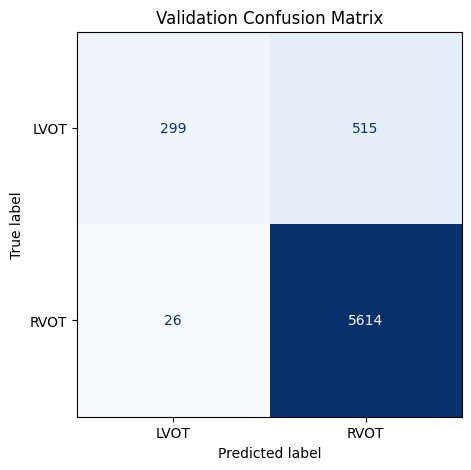

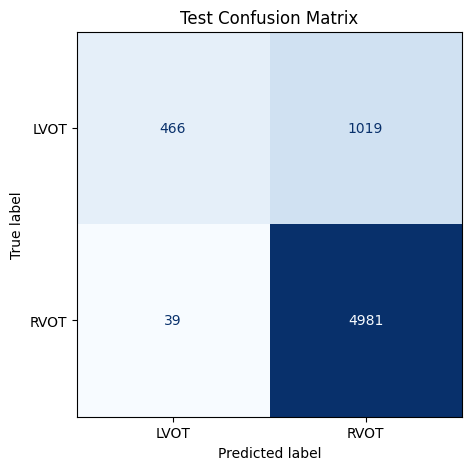

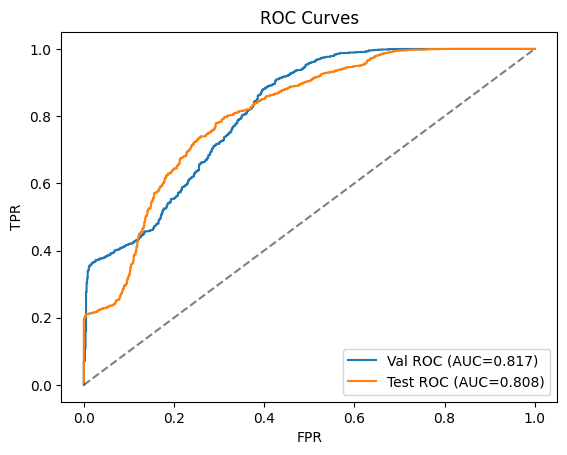

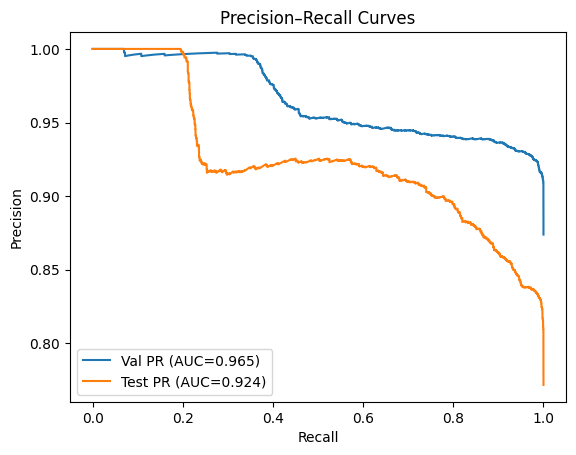

<Figure size 800x600 with 0 Axes>

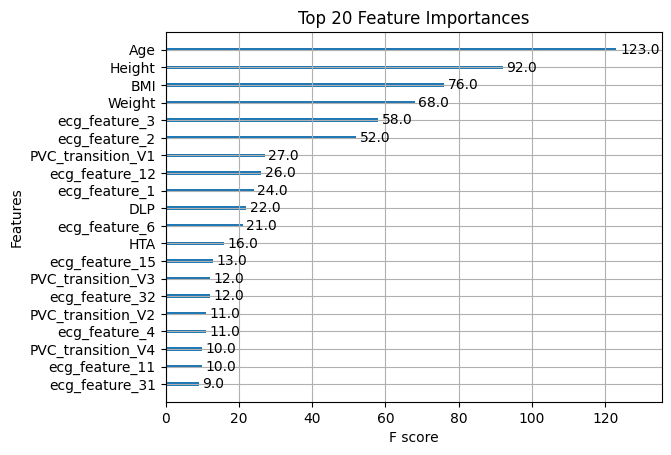

In [8]:
best_model = xgb.XGBClassifier()
best_model.load_model('outputs/xgb_pr_best_model_B.bin')

evaluate_with_auto_threshold(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    calibrate=True,
    calibrator_method='sigmoid'
)